In [1]:
#!/usr/bin/env python3
import pandas
import lz4.frame
import gzip
import io
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import datetime
import matplotlib.pyplot as plt

from glob import glob
from plumbum.cmd import rm

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def load_data(filename, filter_initial=True):
  df = pq.read_table(filename).to_pandas()
  if filter_initial:
    df = df[df['Event Type'] != 'Initial']
  return df

def get_second_data(df, current_second):
  time = sec2string(current_second)
  return df.loc[df['Event Time'].values == time]

def get_minute_data(df, current_minute):
  time = min2string(current_minute)
  next_time = min2string(current_minute + 1)
  return df.loc[(df['Event Time'].values >= time) & (df['Event Time'].values < next_time)]

In [3]:
def sec2string(sec):
  m, s = divmod(sec, 60)
  h, m = divmod(m, 60)
  return "%02d:%02d:%02d" %(h, m, s)

def min2string(minute):
  h, m = divmod(minute, 60)
  return "%02d:%02d:00" %(h, m)

In [4]:
def get_avg_price(df_chunk, percent_change, prev_price, when):
  df_chunk = filter_df(df_chunk, event_type='Fill')
  if (len(df_chunk) == 0) or (percent_change == 0.0):
    current_avg_price = prev_price
  else:
    if when == 'start':
      current_avg_price = df_chunk.iloc[0, -1]
    elif when == 'end':
      current_avg_price = df_chunk.iloc[-1, -1]
  return current_avg_price

def calc_percent_change(current_price, prev_price):
  try:
    percent_change = (current_price - prev_price) / prev_price
  except:
    percent_change = None
  return percent_change

In [5]:
def filter_df(df_chunk, side=None, event_type=None, order_type=None):
  if side is not None:
    df_chunk = df_chunk.loc[df_chunk['Side'].values == side]
  if event_type is not None:
    df_chunk = df_chunk.loc[df_chunk['Event Type'].values == event_type]
  if order_type is not None:
    df_chunk = df_chunk.loc[df_chunk['Order Type'].values == order_type]
  return df_chunk 

def get_frequency(df_chunk):
  return len(df_chunk)
             
def get_volume(df_chunk, volume_type=None):
  if volume_type=='filled':
    return sum(df_chunk['Fill Price (USD)'] * df_chunk['Fill Quantity (BTC)'])
  if volume_type=='unfilled':
    return sum(df_chunk['Limit Price (USD)'] * df_chunk['Original Quantity (BTC)'])

def calculate_percentage(value1, value2):
  try:
    percentage = value1 / (value1 + value2)
  except:
    percentage = None
  return percentage

In [6]:
def one_hot(index, length):
  onehot = [0.]*length
  onehot[index] = 1.
  return onehot
    
def extract_temporal_features(df_chunk):
#   try:
#     year, month, day = df_chunk['Event Date'].values[0].split('-')
#   except:
#     print(minute)
  year, month, day = df_chunk['Event Date'].values[0].split('-')
  day_of_week = int(datetime.datetime(int(year), int(month), int(day)).weekday())
  hour = int(df_chunk['Event Time'].values[0][0:2])
  month = int(month) - 1
  return one_hot(month, 12), one_hot(day_of_week, 7), one_hot(hour, 24)

In [7]:
## Values to compute:

# Price:
# Percent change


# Buys:
# Volume of Filled Markets
# Volume of Filled Limits
# Volume of Placed Limits
# Volume of Cancelled Limits

# Frequency of Filled Markets
# Frequency of Filled Limits
# Frequency of Placed Limits
# Frequency of Cancelled Limits


# Sells:
# Volume of Filled Markets
# Volume of Filled Limits
# Volume of Placed Limits
# Frequency of Filled Markets
# Frequency of Filled Limits
# Frequency of Placed Limits

# Frequency of Filled Markets
# Frequency of Filled Limits
# Frequency of Placed Limits
# Frequency of Cancelled Limits

In [8]:
def vol_freq(df_chunk, volume_type):
  return get_volume(df_chunk, volume_type=volume_type), get_frequency(df_chunk)

def get_raw_features(df_chunk, side=None):
  x = {}
  x['vol_markets'], x['freq_markets']                   = vol_freq(filter_df(df_chunk, side=side, event_type=None, order_type='market'), volume_type='filled')
  x['vol_filled_limits'], x['freq_filled_limits']       = vol_freq(filter_df(df_chunk, side=side, event_type='Fill', order_type='limit'), volume_type='filled')
  x['vol_placed_limits'], x['freq_placed_limits']       = vol_freq(filter_df(df_chunk, side=side, event_type='Place', order_type='limit'), volume_type='unfilled')
  x['vol_cancelled_limits'], x['freq_cancelled_limits'] = vol_freq(filter_df(df_chunk, side=side, event_type='Cancel', order_type='limit'), volume_type='unfilled')  
  return x 

def compute_features(x_buy, x_sell):
  # Buys:
  # -Volume of Filled Markets vs Filled Limits
  # -Volume of Placed Limits vs Filled Limits
  # -Frequency of Filled Markets vs Filled Limits
  # -Frequency of Placed Limits vs Filled Limits

  # Sells:
  # -Volume of Filled Markets vs Filled Limits
  # -Volume of Placed Limited vs Filled Limits
  # -Frequency of Filled Markets vs Filled Limits
  # -Frequency of Placed Limits vs Filled Limits

  # Buys vs Sells:
  # -Volume of Filled Market Sells vs Volume of Filled Market Buys
  # -Volume of Placed Limit Sells vs Volume of Placed Limit Buys
  # -Volume of Cancelled Limit Sells vs Volume Cancelled Limit Buys
  # -Frequency of Filled Market Sells vs Frequency of Filled Market Buys
  # -Frequency of Placed Limit Sells vs Frequency of Placed Limit Buys
  # -Frequency of Cancelled Limit Sells vs Frequency of Cancelled Limit Buys
  
  features = []
  # Buys:
  features.append(calculate_percentage(x_buy['vol_markets'],        x_buy['vol_filled_limits']))
  features.append(calculate_percentage(x_buy['vol_placed_limits'],  x_buy['vol_filled_limits']))
  features.append(calculate_percentage(x_buy['freq_markets'],       x_buy['freq_filled_limits']))
  features.append(calculate_percentage(x_buy['freq_placed_limits'], x_buy['freq_filled_limits']))

  # Sells:
  features.append(calculate_percentage(x_sell['vol_markets'],        x_sell['vol_filled_limits']))
  features.append(calculate_percentage(x_sell['vol_placed_limits'],  x_sell['vol_filled_limits']))
  features.append(calculate_percentage(x_sell['freq_markets'],       x_sell['freq_filled_limits']))
  features.append(calculate_percentage(x_sell['freq_placed_limits'], x_sell['freq_filled_limits']))

  # Buys vs Sells:
  features.append(calculate_percentage(x_sell['vol_markets'],           x_buy['vol_markets']))
  features.append(calculate_percentage(x_sell['vol_placed_limits'],     x_buy['vol_placed_limits']))
  features.append(calculate_percentage(x_sell['vol_cancelled_limits'],  x_buy['vol_cancelled_limits']))
  features.append(calculate_percentage(x_sell['freq_markets'],          x_buy['freq_markets']))
  features.append(calculate_percentage(x_sell['freq_placed_limits'],    x_buy['freq_placed_limits']))
  features.append(calculate_percentage(x_sell['freq_cancelled_limits'], x_buy['freq_cancelled_limits']))

  return features

In [9]:
def get_all_features(df_chunk, percent_change, prev_price):
  
  # Current price, percent change
  current_price = get_avg_price(df_chunk, percent_change, prev_price, when='end')
  percent_change = calc_percent_change(current_price, prev_price)
  
  feature_vec = [current_price, percent_change]
  
  # Order book features
  x_buy  = get_raw_features(df_chunk, side='buy')
  x_sell = get_raw_features(df_chunk, side='sell')
  feature_vec.extend(compute_features(x_buy, x_sell))
  
  # Temporal features
  month_vec, day_vec, hour_vec = extract_temporal_features(df_chunk)
  feature_vec.extend(month_vec)
  feature_vec.extend(day_vec)
  feature_vec.extend(hour_vec)
  
  return feature_vec

In [10]:
def write_tmp_parquet(df, outfile):
  outfile = outfile.replace('cboe/parquet_BTCUSD/', 'cboe/parquet_preprocessed_BTCUSD/')
  pq.write_table(pa.Table.from_pandas(df), outfile, compression='snappy')

In [11]:
def preprocess_day(filename, visualize=True, write_parquet=False, verbose=True):
  print(filename)
  df = load_data(filename, filter_initial=True)
  
  # Initialize previous price
  percent_change=0.0
  prev_price = get_avg_price(df, percent_change=None, prev_price=None, when='start')
  print(prev_price)
  
  # Compute feature vector for each minute of the day
  all_X = []
  for minute in range(24*60):
    if verbose:
      if minute%100 == 0:
        print('Minutes:', minute)

    # Select one minute of data from order book
    df_chunk = get_minute_data(df, minute)
    if len(df_chunk) == 0: # skip minutes with no data
      continue
    
    # Extract features, X
    #print(df_chunk)
    #print(minute, prev_price)
    X = get_all_features(df_chunk, percent_change, prev_price)
    all_X.append(X)
    prev_price = X[0]
    percent_change = X[1]
    
  # Convert to pandas DF
  new_df = pandas.DataFrame.from_records(all_X) 
  
  # Compute labels, Y
  new_df = calculate_y(new_df)
  
  # Write DF to tmp file to later be concatenated with all others
  if write_parquet:
    write_tmp_parquet(new_df, filename)

  # Visualize
  if visualize:
    visualize_features(new_df)

  return new_df

In [12]:
def check_number_of_events(df, timesteps, resolution='minute', event_type=None, order_type=None):
  
  # Filter data
  if event_type is not None:
    df = df.loc[df['Event Type'].values == event_type]
  if order_type is not None:
    df = df.loc[df['Order Type'].values == order_type]
  
  chunk_lengths = []
  # Minute resolution
  if resolution == 'minute':
    for minute in range(timesteps):
      chunk_lengths.append(len(get_minute_data(df, minute)))
      if minute%200 == 0:
        print('Minute:', minute)
        
  # Second resolution
  elif resolution == 'second':
    for sec in range(timesteps):
      chunk_lengths.append(len(get_second_data(df, sec)))
      if sec%100 == 0:
        print('Second', sec)

  # Visualize
  plt.figure(figsize=(20,2));
  plt.plot(chunk_lengths);
  plt.figure(figsize=(20,5));
  plt.hist(chunk_lengths, bins=40);
  
  return chunk_lengths

In [13]:
def calculate_y(new_df):
  new_df['y_percent_change'] = new_df.iloc[:,0]
  new_df['y_percent_change'] = new_df['y_percent_change'].shift(-1)
  new_df = new_df[:-1]
  return new_df

In [14]:
def visualize_features(df):
  for column_idx in range(15):
    df.plot(y = column_idx, figsize=(20,2))

In [15]:
# # Visualize events
# event_type = "Fill"
# order_type = None
# resolution = 'minute'
# timesteps = 24*60

# chunk_lengths = check_number_of_events(df, timesteps=timesteps, resolution=resolution,
#                                        event_type=event_type, order_type=order_type)

In [19]:
# # Preprocess all files
filenames = sorted(glob('cboe/parquet_BTCUSD/*.parquet'))
count = 0
for filename in filenames:
  preprocess_createXY_single_day(filename, visualize=False)
  count += 1
  print(count, '/', len(filenames))

NameError: name 'preprocess_createXY_single_day' is not defined

In [ ]:
for filename in sorted(glob('cboe/parquet_BTCUSD/*.parquet')):
  preprocess_day(filename, visualize=False, write_parquet=True, verbose=False)

cboe/parquet_BTCUSD/BTCUSD_order_book_20170219.parquet
1058.44
Minutes: 0
Minutes: 100
Minutes: 200
Minutes: 300
Minutes: 400
Minutes: 500
Minutes: 600
Minutes: 700
Minutes: 800
Minutes: 900
Minutes: 1000
Minutes: 1100
Minutes: 1200
Minutes: 1300
Minutes: 1400


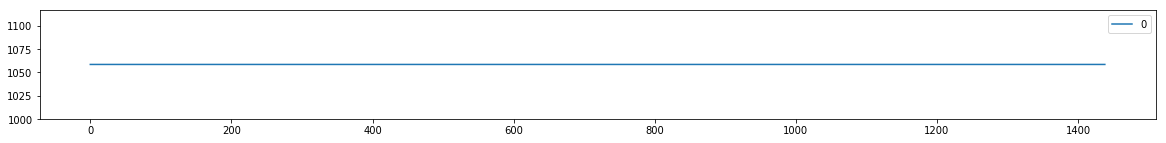

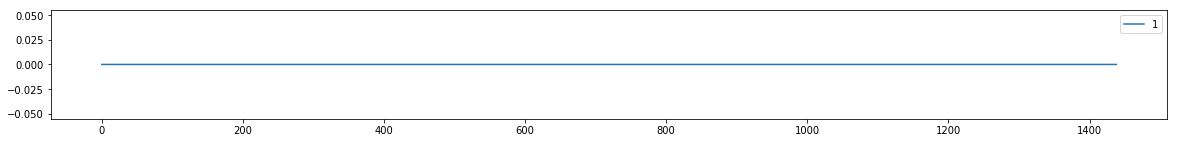

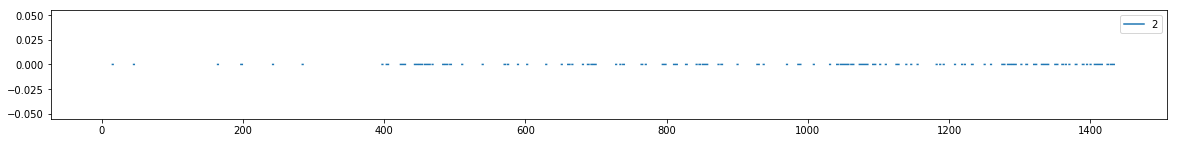

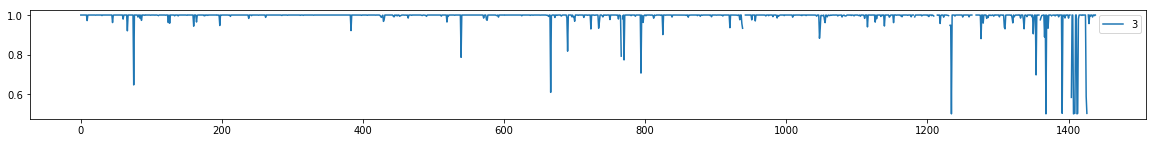

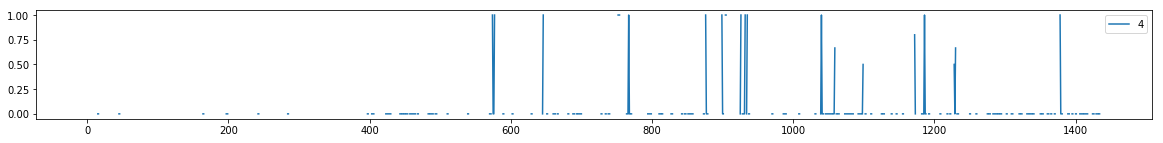

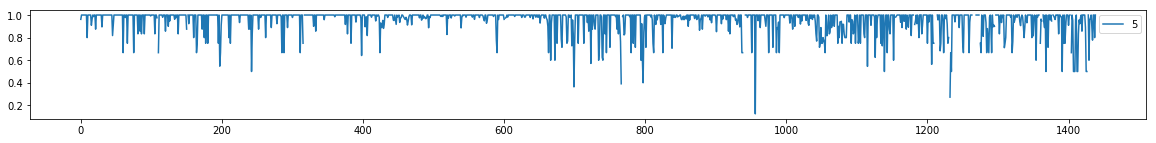

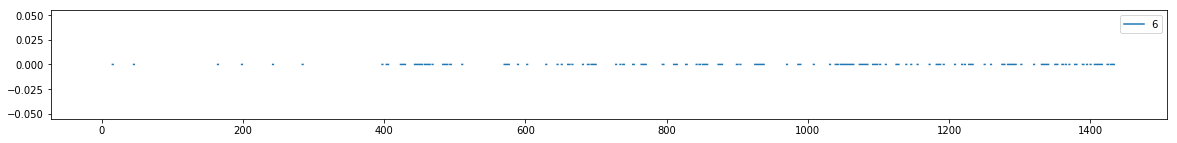

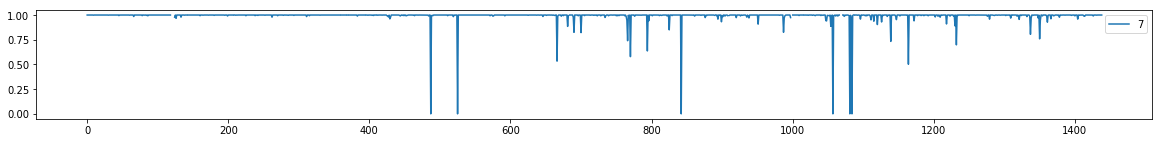

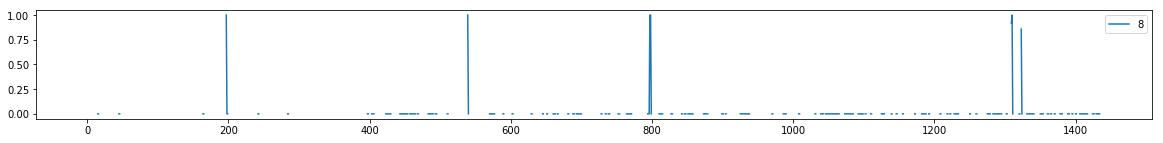

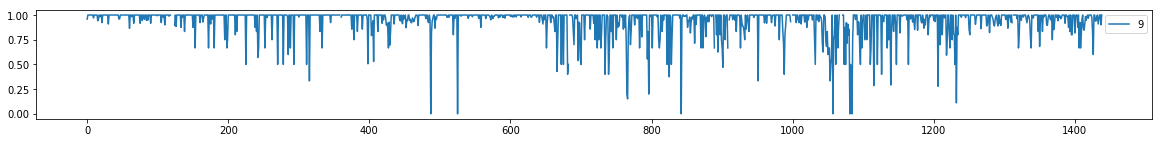

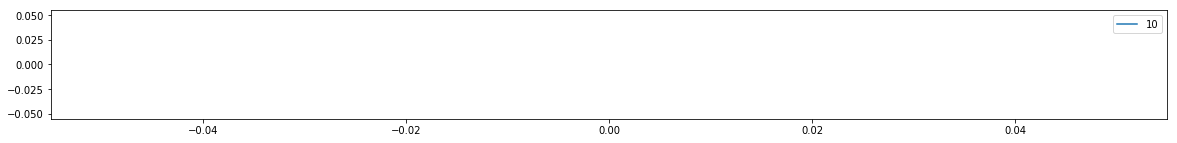

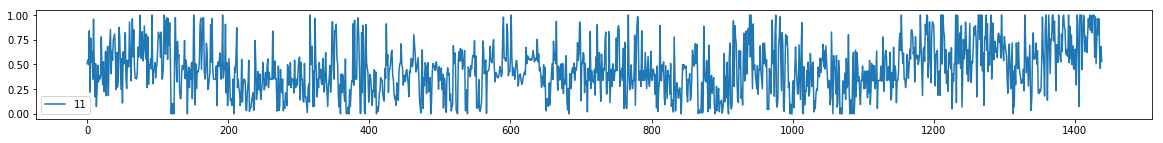

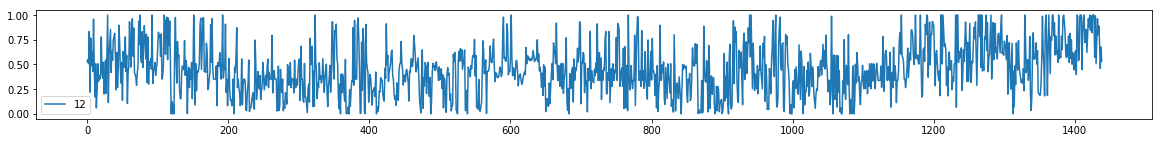

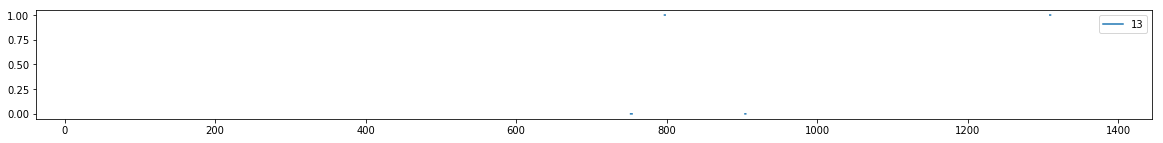

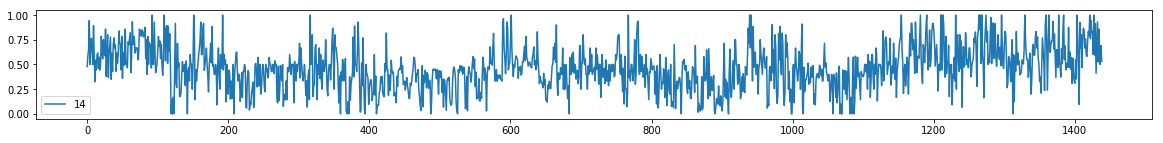

In [17]:
#test_days = [760, 761, 861, 866]
#test_days = [500]
#for day in test_days:
#  filename = sorted(glob('cboe/parquet_BTCUSD/*.parquet'))[day]
#  new_df = preprocess_day(filename)

In [18]:
test_days = [760, 761, 861, 866]
test_days = [0]
for day in test_days:
  filename = sorted(glob('cboe/parquet_BTCUSD/*.parquet'))[day]
  new_df = preprocess_day(filename, write_parquet=False, visualize=True, verbose=True)

cboe/parquet_BTCUSD/BTCUSD_order_book_20151008.parquet
242.5
Minutes: 0
Minutes: 100
Minutes: 200
Minutes: 300
Minutes: 400
Minutes: 500
Minutes: 600
Minutes: 700


ValueError: No axis named 0 for object type <class 'pandas.core.frame.DataFrame'>

In [ ]:
df = load_data(filename, filter_initial=True)

# Initialize previous price
percent_change=0.0
prev_price = get_avg_price(df, percent_change=None, prev_price=None, when='start')

In [ ]:
prev_price